In [4]:
from utils import train_and_search, plot_results, handle_param_names, show_value_counts, plot_grid, plot_cf_matrix
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier


Mean ROC AUC: 0.932


In [5]:
SEED = 42

In [6]:

# loading data
df = pd.read_csv('../dataset/bank-preprocessed.csv')

# dimensions of the datase
print(df.shape)

# converting data
X = df.drop(columns=['y', 'duration'], axis=1)
y = df['y']

# seed for reproducibility
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED)

(43294, 46)


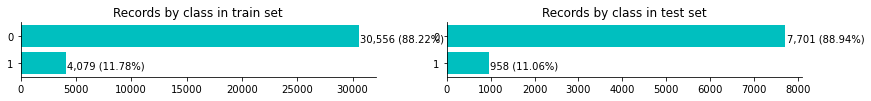

<Figure size 360x720 with 0 Axes>

<Figure size 360x720 with 0 Axes>

In [7]:
train_plotting_infos = [{'serie': y_train, 'title': 'Records by class in train set'},
                        {'serie': y_test, 'title': 'Records by class in test set'}]
plot_grid([[show_value_counts, plotting_info] for plotting_info in train_plotting_infos], 
            n_cols=2, width_scale=7, height_scale=1)

In [12]:
import pandas as pd

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, KFold

def cross_val_imbalanced(model, X_train, y_train, params={}, cv=None, sampler=None):
    X_train = X_train.values
    y_train = y_train.values
    if cv is None:
        cv = KFold(n_splits=10, random_state=seed, shuffle=True)

    if sampler is None:
        sampler = SMOTE(random_state=seed)
    
    results = pd.DataFrame([])
    print(f"Params: {params}")
    for kf_index, (train_ix, valid_ix) in enumerate(cv.split(X_train, y_train)):
        model_obj = model(random_state=SEED, **params)
        X_train_fold, X_val_fold = X_train[train_ix], X_train[valid_ix]
        y_train_fold, y_val_fold = y_train[train_ix], y_train[valid_ix]
        # summarize train and test composition
        train_0, train_1 = len(y_train_fold[y_train_fold==0]), len(y_train_fold[y_train_fold==1])
        val_0, val_1 = len(y_val_fold[y_val_fold==0]), len(y_val_fold[y_val_fold==1])
        print('K-fold (%d) >Before resampler - Train: 0=%d, 1=%d, Val: 0=%d, 1=%d' % (kf_index, train_0, train_1, val_0, val_1))
        X_train_fold_resampled, y_train_fold_resampled = sampler.fit_resample(X_train_fold, y_train_fold)
        train_0_resampled, train_1_resampled = len(y_train_fold_resampled[y_train_fold_resampled==0]), len(y_train_fold_resampled[y_train_fold_resampled==1])
        print('K-fold (%d) >After resampler - Train: 0=%d, 1=%d, Val: 0=%d, 1=%d' % (kf_index, train_0_resampled, train_1_resampled, val_0, val_1))
        model_obj.fit(X_train_fold_resampled, y_train_fold_resampled)
        train_score = f1_score(y_train_fold_resampled, model_obj.predict(X_train_fold_resampled))
        val_score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        print(f'Train Score: {train_score:.3f}, Val Score: {val_score:.3f}')
        results = results.append({"params": params, "kfold": kf_index, "train_score": train_score, "val_score": val_score}, ignore_index=True)
    return model_obj, results

In [9]:
def run_experiment(model_class=MLPClassifier, params={}):
    trained_model, results = cross_val_imbalanced(model_class, X_train, y_train, params=params)
    print("Média de Treino: ", results['train_score'].mean())
    print("Média de Validação: ", results['val_score'].mean())
    print("Média de Teste: ", f1_score(y_test, trained_model.predict(X_test)))
    results = results.sort_values('val_score', ascending=False)
    return {'trained_model': trained_model, 'params': params, 'results': results}

In [10]:
classifiers = []

In [11]:
# treinamento do MLP sem parâmetros
params = {}
classifiers.append(run_experiment(MLPClassifier, params))


Params: {}
K-fold (0) >Before resampler - Train: 0=27514, 1=3657, Val: 0=3042, 1=422
K-fold (0) >After resampler - Train: 0=27514, 1=27514, Val: 0=3042, 1=422
Train Score: 0.897, Val Score: 0.264
K-fold (1) >Before resampler - Train: 0=27528, 1=3643, Val: 0=3028, 1=436
K-fold (1) >After resampler - Train: 0=27528, 1=27528, Val: 0=3028, 1=436
Train Score: 0.929, Val Score: 0.303
K-fold (2) >Before resampler - Train: 0=27506, 1=3665, Val: 0=3050, 1=414
K-fold (2) >After resampler - Train: 0=27506, 1=27506, Val: 0=3050, 1=414
Train Score: 0.811, Val Score: 0.094
K-fold (3) >Before resampler - Train: 0=27531, 1=3640, Val: 0=3025, 1=439
K-fold (3) >After resampler - Train: 0=27531, 1=27531, Val: 0=3025, 1=439
Train Score: 0.911, Val Score: 0.267
K-fold (4) >Before resampler - Train: 0=27476, 1=3695, Val: 0=3080, 1=384
K-fold (4) >After resampler - Train: 0=27476, 1=27476, Val: 0=3080, 1=384
Train Score: 0.907, Val Score: 0.352
K-fold (5) >Before resampler - Train: 0=27508, 1=3664, Val: 0=30

d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## Testando uma rede neural com parâmetros com SMOTE oversampling

In [13]:
# treinamento do MLP sem parâmetros
params = {
    'hidden_layer_sizes': (50,50,50),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'learning_rate': 'adaptive',
}
classifiers.append(run_experiment(MLPClassifier, params))


Params: {'hidden_layer_sizes': (50, 50, 50), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive'}
K-fold (0) >Before resampler - Train: 0=27514, 1=3657, Val: 0=3042, 1=422
K-fold (0) >After resampler - Train: 0=27514, 1=27514, Val: 0=3042, 1=422
Train Score: 0.929, Val Score: 0.301
K-fold (1) >Before resampler - Train: 0=27528, 1=3643, Val: 0=3028, 1=436
K-fold (1) >After resampler - Train: 0=27528, 1=27528, Val: 0=3028, 1=436
Train Score: 0.920, Val Score: 0.255
K-fold (2) >Before resampler - Train: 0=27506, 1=3665, Val: 0=3050, 1=414
K-fold (2) >After resampler - Train: 0=27506, 1=27506, Val: 0=3050, 1=414
Train Score: 0.926, Val Score: 0.225
K-fold (3) >Before resampler - Train: 0=27531, 1=3640, Val: 0=3025, 1=439
K-fold (3) >After resampler - Train: 0=27531, 1=27531, Val: 0=3025, 1=439
Train Score: 0.936, Val Score: 0.372
K-fold (4) >Before resampler - Train: 0=27476, 1=3695, Val: 0=3080, 1=384
K-fold (4) >After resampler - Train: 0=27476, 1=27476, V

d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## Testando uma rede neural com Tensorflow com parâmetros com SMOTE oversampling

In [18]:
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# treinamento do MLP sem parâmetros


mlp = MLPClassifier
params = {
    'hidden_layer_sizes': (50,50,50),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'learning_rate': 'adaptive',
}
# results = cross_val_imbalanced(mlp, X_train, y_train, params=params)
# print("Média de treino: ", results['train_score'].mean())
# print("Média de Validação: ", results['val_score'].mean())
# results.sort_values('val_score', ascending=False)

In [28]:
# Comitê com votação entre os classificadores com AdaBoostClassifier
import numpy as np
import pandas
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import tree
seed = 1075
np.random.seed(seed)

#training ensembles of classifiers
clf_array = [dt, svc]
for clf in clf_array:
    pima_scores = cross_val_score(clf, X, Y, cv=10)
    boosting_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=3, random_state=seed)
    boosting_scores = cross_val_score(boosting_clf, X, Y, cv=10)    
    print('Media clf ',pima_scores.mean(), 'Desvio ',pima_scores.std(), 'Media Bagging',boosting_scores.mean(), 'Desvio ',boosting_scores.std())

FileNotFoundError: [Errno 2] No such file or directory: 'pima-indians-diabetes.csv'

In [ ]:
# Get some classifiers to evaluate with BaggingClassifier
import numpy as np
import pandas
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# Create base classifiers
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svc = SVC(kernel='linear')
rg = RidgeClassifier()

#training ensembles of classifiers
clf_array = [rf, knn, svc, rg]
for clf in clf_array:
    pima_scores = cross_val_score(clf, X, Y, cv=10)
    bagging_clf = BaggingClassifier(clf,max_samples=0.3, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, Y, cv=10)    
    print('Media clf ',pima_scores.mean(), 'Desvio ',pima_scores.std(), 'Media Bagging',bagging_scores.mean(), 'Desvio ',bagging_scores.std())

Media clf  0.7617224880382775 Desvio  0.049688240527885306 Media Bagging 0.7617395762132604 Desvio  0.04877493503738191
Media clf  0.7213773069036227 Desvio  0.04416817250533367 Media Bagging 0.7474538619275461 Desvio  0.03919108390131277
Media clf  0.7669685577580314 Desvio  0.03338716735131549 Media Bagging 0.7695830485304171 Desvio  0.029390886031526838
Media clf  0.7734962406015038 Desvio  0.03417526057730609 Media Bagging 0.7721633629528366 Desvio  0.03128714178833154


In [ ]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
df = pandas.read_csv("pima-indians-diabetes.csv", names=names)
array = df.values
X = array[:,0:8]
Y = array[:,8]
seed = 5
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed)

# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC(kernel='linear')
estimators.append(('svm', model3))

#train


# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

0.7721633629528367


>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.823 (0.041)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)
>stacking 0.963 (0.019)


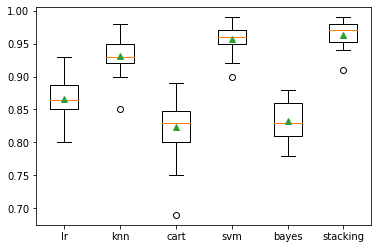

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()